In [123]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from astropy.table import Table
from astropy.io import ascii
import os
from astropy.table import QTable
from scipy.stats import spearmanr
from scipy import stats
from numpy import percentile

#remove scientific notation from output lists (prints 0.112 rather than 0.112000000e+00 for a float array element)
#np.set_printoptions(suppress=True)

In [2]:
homedir = os.getenv("HOME")

#sga matched to VF catalog
sgacut = Table.read(homedir+'/sga_cut.fits',format='ascii')

#sga r50 parameters
sga_params = Table.read(homedir+'/sga_params')

#names (for later check purposes)
vfid = sgacut['VFID']

In [131]:
tay = sgacut[(t2['nsersic']>4)]
tay.write('vf_largeser.fits',overwrite=True)

In [3]:
#resizing sga_params table to only contain sgacut entries,
flag_p = []

for i in sga_params['name']:
    if i not in sgacut['VFID']:
        flag_p.append(False)
    else:
        flag_p.append(True)

sga_params = sga_params[flag_p]

#output is only 933, as compared with 1020 found previously with SGA-parent-v3.0.fits

In [4]:
#resizing sgacut to be compatible with sga_params...that is, both will have size 933

flag_p = []

for i in sgacut['VFID']:
    if i not in sga_params['name']:
        flag_p.append(False)
    else:
        flag_p.append(True)

sgacut = sgacut[flag_p]
vfid = vfid[flag_p]

In [5]:
#Note: VFIDs are not in order for sga_params, so we will use np.where to determine correct indices

# -------------------------------------------------------------------------------------------

In [6]:
#isolate late-type galaxies from sample using t-test
#the t-type is available in Hyperleda catalog, so will pull and cut this first 
#I worry doing so will restrict the sample even further, as there may be galaxies with an empty 
#classification cell. But I proceed.

hyp = Table.read(homedir+'/Desktop/v1-20210308/vf_north_v1_hyperleda.fits')

#for AGN cuts (see seven cells below), pull WISE catalog
wise = Table.read(homedir+'/Desktop/v1-20210308/vf_north_v1_unwise.fits')

#for BPT AGN cuts, pull nsa_v0 catalog
bpt = Table.read(homedir+'/Desktop/v1-20210308/vf_north_v1_nsa_v0.fits')

#env
env = Table.read(homedir+'/Desktop/v1-20210308/vf_north_v1_main_envsummary_Kourkchi.fits')

In [7]:
#I will add the name column to the wise table for ease of comparison -- otherwise, no comparison can occur.
wise.add_column(hyp['VFID'],name='VFID')

In [8]:
#resizing hyp to be compatible with subsample cut...that is, both will have size 933

flag_hyp = []

for i in hyp['VFID']:
    if i not in sga_params['name']:
        flag_hyp.append(False)
    else:
        flag_hyp.append(True)

hyp = hyp[flag_hyp]
wise = wise[flag_hyp]
bpt = bpt[flag_hyp]
env = env[flag_hyp]

In [9]:
#numerical Hubble stage/morphological types as defined on Hyperleda website:

V_class = []
for i in hyp['type_1']:
    if i not in V_class:
        V_class.append(i)

In [10]:
V_class = np.asarray(V_class).flatten()
V_class

array(['SABb', 'Sb', 'SABa', 'Sc', 'E', 'Sbc', 'Sab', 'SBbc', 'Sa', 'SBa',
       'SBcd', 'S?', 'SBb', 'S0-a', 'S0', 'N/A', 'SABc', 'Scd', 'E?',
       'SBc', 'E-S0', 'SBab', 'I', 'Sd', 'Sm', 'SABm', 'SBm', '0.0', 'IB',
       'SBd', 'SABd'], dtype='<U32')

In [11]:
#again using the website, the corresponding codes are
t_type = [2,3,2,5,-5,4,2,3,1,3,4,1,3,0,-2,-999,2,6,-5,4,-3,4,10,
         7,9,2,3,-999,10,4,2]

In [12]:
#I will now cut according to t_type>=1, then resize the sga_params table

flag = []
for i in range(0,len(hyp)):
    index = np.where(V_class == hyp['type_1'][i])[0]
    try:
        index = index[0]
        if int(t_type[index]) >= 1:
            flag.append(True)
        else:
            flag.append(False)
    except:
        #any miscellaneous hocus pocus is deserving of a 'false' designation
        flag.append(False)
        continue
        
hyp = hyp[flag]
wise = wise[flag]
bpt = bpt[flag]
env = env[flag]

/Users/k215c316/opt/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:4072: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = compare(sdata, odata)


In [13]:
#ANOTHER CUT: **large** size ratio outliers
outlier_vfid = ['VFID0432','VFID0957','VFID1533','VFID1654','VFID1932','VFID2627','VFID3982','VFID4272','VFID4876']

In [14]:
flag2 = []
for i in hyp['VFID']:
    if i in outlier_vfid:
        flag2.append(False)
    else:
        flag2.append(True)

hyp = hyp[flag2]
wise = wise[flag2]
bpt = bpt[flag2]
env = env[flag2]

In [15]:
#one final cut --> AGN
#  can use WISE colors to isolate galaxies with AGN from sample
#      W1-W2 > 0.75, W2-W3 < 4.0
#Asmus+20, Jarret+17 in agreement with these cut selections
wise_agn = wise['VFID'][np.where((wise['w1_mag'] - wise['w2_mag']>0.75) & (wise['w2_mag']-wise['w3_mag']<4.0))[0]]
wise_agn

VFID1662
VFID2171
VFID2622
VFID2774
VFID3711
VFID4129


In [16]:
#when visually inspected, the following GALFIT models/residuals imply AGN:
#VFID1662(unsure), VFID2171(YES), VFID2622(yes), VFID2774(yes), VFID3711(yes), VFID4129(yes)

In [17]:
#compare to hyp catalog:
hyp_agn = hyp['VFID'][np.where(hyp['agnclass']!='N/A')[0]]
print(len(hyp_agn))

69


In [18]:
for i in wise_agn:
    if i in hyp_agn:
        print(i)

VFID2171
VFID2622
VFID3711


In [19]:
#a bit puzzling. wise_agn contains 6 galaxies, while hyp_agn contains 69; and yet, only 3 galaxies appear in both.
#However, since Hyperleda agnclass elements originate from multiple literature sources, not as reliable...
#WISE colors, it is.

In [20]:
#generate WISE flag (removes WISE AGN from sample)
wise_agn_flag = []
for i in wise['VFID']:
    wise_agn_flag.append(i not in wise_agn)
    
#will use a bit later to mark AGN galaxies -- we do not wish to altogether exclude the buggers at this time.

In [21]:
#do likewise for BPT spectral data!
#code courtesy of Rose Finn
agn_kauffman = (np.log10(bpt['O3FLUX']/bpt['HBFLUX']) > (.61/(np.log10(bpt['N2FLUX']/bpt['HAFLUX']-.05))+1.3)) | (np.log10(bpt['N2FLUX']/bpt['HAFLUX']) > 0.)
agn_kauffman_flag = np.asarray(agn_kauffman)

<ipython-input-21-d3af183f6a37>:3: RuntimeWarning: invalid value encountered in true_divide
  agn_kauffman = (np.log10(bpt['O3FLUX']/bpt['HBFLUX']) > (.61/(np.log10(bpt['N2FLUX']/bpt['HAFLUX']-.05))+1.3)) | (np.log10(bpt['N2FLUX']/bpt['HAFLUX']) > 0.)
<ipython-input-21-d3af183f6a37>:3: RuntimeWarning: invalid value encountered in log10
  agn_kauffman = (np.log10(bpt['O3FLUX']/bpt['HBFLUX']) > (.61/(np.log10(bpt['N2FLUX']/bpt['HAFLUX']-.05))+1.3)) | (np.log10(bpt['N2FLUX']/bpt['HAFLUX']) > 0.)


In [22]:
#annnd, now apply new flag to sga_params and sgacut such that len(hyp) == len(sga_params) == len(sgacut)

#sga_params (optical radius parameters) flag
flag_sga = []
#sgacut flag (Virgo catalog cut to only include galaxies with optical radius parameters)
flag_sga2 = []

for i in sga_params['name']:
    if i not in hyp['VFID']:
        flag_sga.append(False)
    else:
        flag_sga.append(True)

for i in sgacut['name']:
    if i not in hyp['VFID']:
        flag_sga2.append(False)
    else:
        flag_sga2.append(True)
        
sga_params = sga_params[flag_sga]
sgacut = sgacut[flag_sga2]
vfid = vfid[flag_sga2]

In [23]:
#confirming that sizes are not mismatched
print('size check')
print(len(sga_params)/len(hyp))
print(' ')
print('number of t_type >= 1 galaxies')
print(len(sgacut))

size check
1.0
 
number of t_type >= 1 galaxies
695


In [24]:
#all set. now, cut GALFIT output parameter tables. 
#first, we summon the tables

#t1 --> no parameters held fixed; no psf
#t2 --> no parameters held fixed; psf
#t3 --> BA, PA held fixed; no psf
#t4 --> BA, PA held fixed; psf

t1 = Table.read(homedir+'/set_one_free_nopsf.txt',format='ascii')
t2 = Table.read(homedir+'/set_one_free_psf.txt',format='ascii')
t3 = Table.read(homedir+'/set_one_fixed_nopsf.txt',format='ascii')
t4 = Table.read(homedir+'/set_one_fixed_psf.txt',format='ascii')

In [25]:
#generate flags that only permit galaxies appearing in SGA to be filtered through

flag_t1 = []
flag_t2 = []
flag_t3 = []
flag_t4 = []

for i in t1['galname']:
    if str(i) not in sgacut['prefix']:
        flag_t1.append(False)
    else:
        flag_t1.append(True)
        
for i in t2['galname']:
    if str(i) not in sgacut['prefix']:
        flag_t2.append(False)
    else:
        flag_t2.append(True)
        
for i in t3['galname']:
    if str(i) not in sgacut['prefix']:
        flag_t3.append(False)
    else:
        flag_t3.append(True)
        
for i in t4['galname']:
    if str(i) not in sgacut['prefix']:
        flag_t4.append(False)
    else:
        flag_t4.append(True)

In [26]:
#cut output parameters using above flags and isolate error columns

t1 = t1[flag_t1]
t2 = t2[flag_t2]
t3 = t3[flag_t3]
t4 = t4[flag_t4]

t1_error = t1['error']
t2_error = t2['error']
t3_error = t3['error']
t4_error = t4['error']

In [27]:
#isolate and convert Re to arcseconds, for compatibility purposes with the optical Re (see two cells below)
#for W3 camera, one px = 2.75 arcsec

re_free_nopsf = t1['re']*2.75
re_free_psf = t2['re']*2.75
re_fixed_nopsf = t3['re']*2.75
re_fixed_psf = t4['re']*2.75

In [28]:
#convert sga params to optical half-light radius for galaxy subsample
#(values are for r-band)
#note: parameters are dimensionless, so multiplying by 10 arcsec yields an r50 in arcsec

r0 = 10 #arcsec
alpha_1 = sga_params['R_COG_PARAMS_ALPHA1']
alpha_2 = sga_params['R_COG_PARAMS_ALPHA2']
m0 = sga_params['R_COG_PARAMS_M0']

comp_one = np.log10(0.5)/(0.4*m0)
comp_two = np.exp(-comp_one) - 1
comp_three = (1/alpha_1) * comp_two
comp_four = comp_three**(-1/alpha_2)

r50_tentative = r0 * comp_four

In [29]:
#sga_param index --> r50 index
#sgacut index --> re index

#first rearrange r50_tentative to match re indices
#vfid_temp is to explicitly establish that order of r50 is correct
vfid_temp = []
r50 = []
for i in range(0,len(sgacut)):
    galname = sgacut['VFID'][i]
    #find index at which sga_params (corresponding to r50_tentative index) fits the sgacut galname 
    index = np.where(sga_params['name'] == galname)[0][0]
    #use that index to extract r50_tentative element and place in r50
    r50.append(r50_tentative[index])
    #do likewise to sga_params galname -- if vfid_temp is in ascending order (as is sgacut), then all is well.
    vfid_temp.append(sga_params[index]['name'])
    
#note: confirmed that indices match...vfid_temp is in correct ascending order, meaning r50 is similarly.

In [30]:
#calculating ratios --> (12-micron Re) / (r-band Re)

re_ratio_free_nopsf = re_free_nopsf/r50
re_ratio_free_psf = re_free_psf/r50
re_ratio_fixed_nopsf = re_fixed_nopsf/r50
re_ratio_fixed_psf = re_fixed_psf/r50

In [31]:
#and filter errors --> galaxies with numerical errors are excluded from analysis

#first convert 0,1 to True, False

t1_error_list = []
t2_error_list = []
t3_error_list = []
t4_error_list = []

for i in range(0,len(sgacut)):
    if t1_error[i] == 0:
        t1_error_list.append(True)
    if (t1_error[i] == 1) | (t1_error[i] == -999):
        t1_error_list.append(False)
    if t2_error[i] == 0:
        t2_error_list.append(True)
    if (t2_error[i] == 1) | (t2_error[i] == -999):
        t2_error_list.append(False)
    if t3_error[i] == 0:
        t3_error_list.append(True)
    if (t3_error[i] == 1) | (t3_error[i] == -999):
        t3_error_list.append(False)    
    if t4_error[i] == 0:
        t4_error_list.append(True)
    if (t4_error[i] == 1) | (t4_error[i] == -999):
        t4_error_list.append(False)

#redefining errors such that int values become bools.
        
t1_error = np.asarray(t1_error_list)
t2_error = np.asarray(t2_error_list)
t3_error = np.asarray(t3_error_list)
t4_error = np.asarray(t4_error_list) 

In [32]:
#then treat the errors as flags...no error behinds left.
#(i.e., remove galaxies with error flags)

#strictly 12-micron Re
re_1 = re_free_nopsf[t1_error]
re_2 = re_free_psf[t2_error]
vfid_2 = vfid[t2_error]
re_3 = re_fixed_nopsf[t3_error]
re_4 = re_fixed_psf[t4_error]
vfid_4 = vfid[t4_error]

#strictly r-band Re
r50_1 = np.asarray(r50)[t1_error]
r50_2 = np.asarray(r50)[t2_error]
r50_3 = np.asarray(r50)[t3_error]
r50_4 = np.asarray(r50)[t4_error]

#Re ratios (recall: 12-micron/r-band)
re_ratio_1 = re_ratio_free_nopsf[t1_error]
re_ratio_2 = re_ratio_free_psf[t2_error]
re_ratio_3 = re_ratio_fixed_nopsf[t3_error]
re_ratio_4 = re_ratio_fixed_psf[t4_error]

#also trim WISE AGN flags...
wise_agn_flag1 = np.asarray(wise_agn_flag)[t1_error]
wise_agn_flag2 = np.asarray(wise_agn_flag)[t2_error]
wise_agn_flag3 = np.asarray(wise_agn_flag)[t3_error]
wise_agn_flag4 = np.asarray(wise_agn_flag)[t4_error]

#annnnd, BPT AGN flags...
kauffman_agn_flag1 = np.asarray(agn_kauffman_flag)[t1_error]
kauffman_agn_flag2 = np.asarray(agn_kauffman_flag)[t2_error]
kauffman_agn_flag3 = np.asarray(agn_kauffman_flag)[t3_error]
kauffman_agn_flag4 = np.asarray(agn_kauffman_flag)[t4_error]

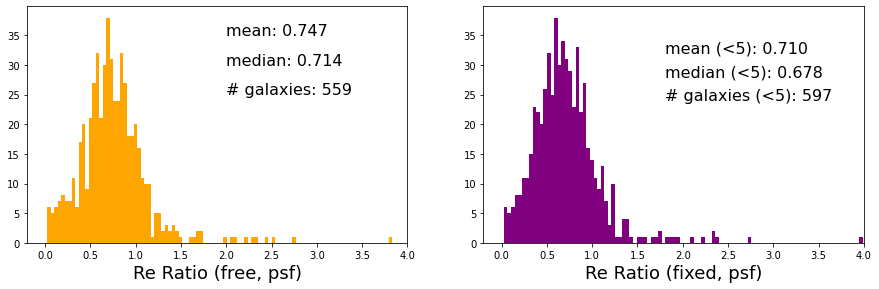

In [33]:
#prelimiary histogram plots (free psf, fixed psf)...

ratio_bins = [re_ratio_2,re_ratio_4[(re_ratio_4<5)]]
colorz = ['orange','purple']
xlabelz = ['Re Ratio (free, psf)','Re Ratio (fixed, psf)']
xlimz = [(-0.2,4),(-0.2,4)]


fig = plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=.3,wspace=.2)

for i in range(1,3):
    ax=fig.add_subplot(2,2,i)
    plt.hist(ratio_bins[i-1],bins=100,color=colorz[i-1])
    plt.xlabel(xlabelz[i-1],fontsize=18)
    plt.xlim(xlimz[i-1])

    if i == 1:
        plt.text(2.0,35,'mean: '+'%.3f'%(np.mean(re_ratio_2)),fontsize=16)
        plt.text(2.0,30,'median: '+'%.3f'%(np.median(re_ratio_2)),fontsize=16)
        plt.text(2.0,25,'# galaxies: '+str(len(re_ratio_2)),fontsize=16)        
    if i == 2:
        plt.text(1.8,32,'mean (<5): '+'%.3f'%(np.mean(re_ratio_4[(re_ratio_4<5)])),fontsize=16)
        plt.text(1.8,28,'median (<5): '+'%.3f'%(np.median(re_ratio_4[(re_ratio_4<5)])),fontsize=16)
        plt.text(1.8,24,'# galaxies (<5): '+str(len(re_ratio_4[(re_ratio_4<5)])),fontsize=16) 

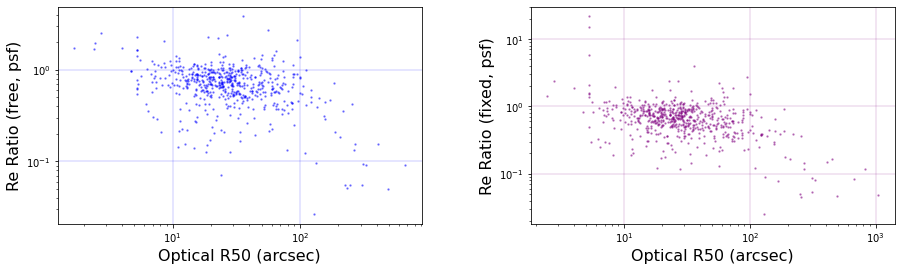

In [34]:
#scatterplots of ratio vs. optical Re

fig = plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=.5,wspace=.3)
for i in range(1,3):
    ax=fig.add_subplot(2,2,i)
    
    if i == 1:
        plt.scatter(r50_2,re_ratio_2,color='blue',alpha=0.4,s=2)
        plt.ylabel('Re Ratio (free, psf)',fontsize=16)
        plt.xlabel('Optical R50 (arcsec)',fontsize=16)   
        plt.xscale('log')
        plt.yscale('log')
        plt.grid(color='b',linewidth=0.2)
    
    if i == 2:
        plt.scatter(r50_4,re_ratio_4,color='purple',alpha=0.4,s=2)
        plt.ylabel('Re Ratio (fixed, psf)',fontsize=16)
        plt.xlabel('Optical R50 (arcsec)',fontsize=16)
        plt.xscale('log')
        plt.yscale('log')
        plt.grid(color='purple',linewidth=0.2)

In [35]:
#Spearman rank correlation test

print('Free Correlation (rho value, all) '+'%0.4f'%spearmanr(r50_2,re_ratio_2)[0])
print('Free Correlation (p value, all) '+'%0.12f'%spearmanr(r50_2,re_ratio_2)[1])
print(' ')
print('Free Correlation (rho value, noWISE_AGN) '+'%0.4f'%spearmanr(r50_2[wise_agn_flag2],re_ratio_2[wise_agn_flag2])[0])
print('Free Correlation (p value, noWISE_AGN) '+'%0.12f'%spearmanr(r50_2[wise_agn_flag2],re_ratio_2[wise_agn_flag2])[1])
print(' ')
print('Free Correlation (rho value, noBPT_AGN) '+'%0.4f'%spearmanr(r50_2[kauffman_agn_flag2],re_ratio_2[kauffman_agn_flag2])[0])
print('Free Correlation (p value, noBPT_AGN) '+'%0.4f'%spearmanr(r50_2[kauffman_agn_flag2],re_ratio_2[kauffman_agn_flag2])[1])
print(' ')
print(' ')
print('Fixed Correlation (rho value, all) '+'%0.4f'%spearmanr(r50_4,re_ratio_4)[0])
print('Fixed Correlation (p value, all) '+'%0.16f'%spearmanr(r50_4,re_ratio_4)[1])
print(' ')
print('Fixed Correlation (rho value, noWISE_AGN) '+'%0.4f'%spearmanr(r50_4[wise_agn_flag4],re_ratio_4[wise_agn_flag4])[0])
print('Fixed Correlation (p value, noWISE_AGN) '+'%0.16f'%spearmanr(r50_4[wise_agn_flag4],re_ratio_4[wise_agn_flag4])[1])
print(' ')
print('Fixed Correlation (rho value, noBPT_AGN) '+'%0.4f'%spearmanr(r50_4[kauffman_agn_flag4],re_ratio_4[kauffman_agn_flag4])[0])
print('Fixed Correlation (p value, noBPT_AGN) '+'%0.7f'%spearmanr(r50_4[kauffman_agn_flag4],re_ratio_4[kauffman_agn_flag4])[1])

#"If the p-value of the correlation is less than 0.05, the correlation is statistically significant."

Free Correlation (rho value, all) -0.2863
Free Correlation (p value, all) 0.000000000005
 
Free Correlation (rho value, noWISE_AGN) -0.2875
Free Correlation (p value, noWISE_AGN) 0.000000000005
 
Free Correlation (rho value, noBPT_AGN) -0.3398
Free Correlation (p value, noBPT_AGN) 0.0010
 
 
Fixed Correlation (rho value, all) -0.3240
Fixed Correlation (p value, all) 0.0000000000000004
 
Fixed Correlation (rho value, noWISE_AGN) -0.3258
Fixed Correlation (p value, noWISE_AGN) 0.0000000000000003
 
Fixed Correlation (rho value, noBPT_AGN) -0.4743
Fixed Correlation (p value, noBPT_AGN) 0.0000007


# SFR v. Mstar plots

In [36]:
#SFR vs. Mstar plots for 704 galaxy subset

(8.3, 11.35)

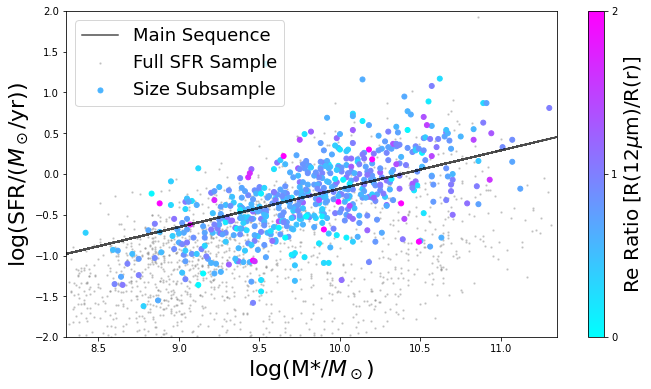

In [37]:
#size ratio v. offset from main sequence (FREE)

#defining subset...mgs from Leroy+19 paper
mgs = Table.read(homedir+'/Desktop/v1-20210308/vf_north_v1_z0mgs.fits')
#cut sample to 933
mgstab = mgs[flag_hyp]
#cut sample to 704 using sgacut flag
mgstab = mgstab[flag_sga2]

Mstar = mgstab['logmass'] #x-axis
SFR = mgstab['logsfr'] #y-axis; frequently found with W4 data
D25 = 10**(hyp['logd25'])

#full catalog...
Mstar_full = mgs['logmass']
SFR_full = mgs['logsfr']

plt.figure(figsize=(11,6))
plt.scatter(Mstar_full,SFR_full,color='gray',s=2,alpha=0.3,label='Full SFR Sample')
plt.scatter(Mstar[t2_error],SFR[t2_error],c=re_ratio_2,cmap='cool',linewidths=1,vmin=0,vmax=2,s=25,alpha=1,label='Size Subsample')

cb = plt.colorbar(ticks=range(0,5,1))

cb.set_label(r'Re Ratio [R(12$\mu$m)/R(r)]',fontsize=20)
plt.xlabel(r'log(M*/$M_\odot$)',fontsize=22)
plt.ylabel(r'log(SFR/($M_\odot$/yr))',fontsize=22)

#best-fit line test...
#slope: 0.47 +/- 0.01
#y-intercept: -4.88 +/- 0.10
y = Mstar_full*0.47 - 4.88

#edgecolors = 'k'

plt.plot(Mstar_full,y,label=('Main Sequence'),color='black',alpha=0.7)

plt.legend(loc='upper left',fontsize=18)

#trim the "gray" perimeter to magnify on the central, colored points
plt.ylim(-2,2)
plt.xlim(8.3,11.35)

#plt.savefig('snr_mstar.png', dpi=300)

In [38]:
#I will now plot distance from MS vs. size ratio
#Distance = (| a*x1 + b*y1 + c |) / (sqrt( a*a + b*b))

d2 = (0.47*Mstar[t2_error] - SFR[t2_error] - 4.88) / (np.sqrt(0.47**2 + 1**2))
d4 = (0.47*Mstar[t4_error] - SFR[t4_error] - 4.88) / (np.sqrt(0.47**2 + 1**2))

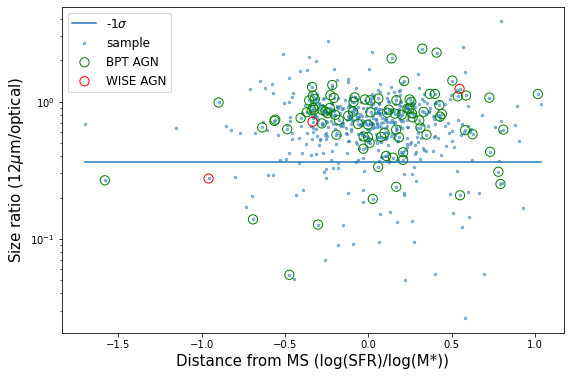

In [122]:
plt.figure(figsize=(9,6))
plt.scatter(d2,re_ratio_2,s=6,alpha=0.5,label='sample')
plt.yscale('log')
plt.ylabel(r'Size ratio (12$\mu$m/optical)',fontsize=15)
plt.xlabel('Distance from MS (log(SFR)/log(M*))',fontsize=15)

plt.scatter(d2[kauffman_agn_flag2], re_ratio_2[kauffman_agn_flag2], s=85, facecolors='none', 
            edgecolors='g',label='BPT AGN')
plt.scatter(d2[~wise_agn_flag2], re_ratio_2[~wise_agn_flag2], s=85, facecolors='none', 
            edgecolors='r',label='WISE AGN')

#plt.plot([np.min(d2),np.max(d2)],[mean_re-std_re,mean_re-std_re],label=r'-1$\sigma$')

plt.legend(loc='upper left',fontsize=12)


In [62]:
#Spearman rank correlation test
#~kauffman_agn_flag excludes BPT AGN
#wise_agn_flag exclude WISE AGN

print('Free Correlation (rho value, no outliers) '+'%0.4f'%spearmanr(d2,re_ratio_2)[0])
print('Free Correlation (p value, no outliers) '+'%0.4f'%spearmanr(d2,re_ratio_2)[1])
print(' ')

#"However, since the p-value of the correlation is not less than 0.05, 
#the correlation is not statistically significant."

Free Correlation (rho value, no outliers) -0.0742
Free Correlation (p value, no outliers) 0.0798
 


# Ratios according to environment bins

In [41]:
#histogram attempt not terribly revealing, especially since I merged bins that should not have been merged.
#instead, will use violin plot to illustrate size ratios as a function of environmental density (the bins
#as defined above)

In [42]:
envcut = env
#envcut column names: flag_clus (0,1), flag_fil (0,1), flag_isol (0,1), flag_gro (0, 1, 2), flag_clus_k (0,1)

In [43]:
#isolate columns; convert 0,1 to False,True

cluster = envcut['flag_clus']
cluster = np.asarray(list(map(bool,cluster)))

filament = envcut['flag_fil']
filament = np.asarray(list(map(bool,filament)))

field = envcut['flag_isol']
field = np.asarray(list(map(bool,field)))

group = envcut['flag_gro']
#poor group
pg_flag = []
#rich group
rg_flag = []

#define rich, poor groups 

for n in range(0,len(envcut)):
    if int(group[n]) == 1:
        rg_flag.append(False)
        pg_flag.append(True)
    if int(group[n]) == 2:
        rg_flag.append(True)
        pg_flag.append(False)
    if int(group[n]) == 0:
        rg_flag.append(False)
        pg_flag.append(False)
        
rg_flag = np.asarray(rg_flag)
pg_flag = np.asarray(pg_flag)

In [44]:
#CL
cluster = cluster

#Filament and rich group
fil_rg = (rg_flag & filament)

#rich group (all, meaning isolated rich groups or those in filaments)
rg_all = (rg_flag)

#rich group only (include if the row only has a "2")
rg = (rg_flag) & (~fil_rg)

#filament (all galaxies with filament marker)
filament = filament

#filament galaxies that do not belong to a rich group
fil_only = (filament) & (~rg_flag)

#poor group
pg_flag = pg_flag

#pure field
field = field

In [45]:
#trimming bool parameters according to galaxies with GALFIT numerical errors, for free case

cluster_free = cluster[t2_error]
fil_rg_free = fil_rg[t2_error]
rg_all_free = rg_all[t2_error]
rg_free = rg[t2_error]
filament_free = filament[t2_error]
filament_iso_free = fil_only[t2_error]
pg_free = pg_flag[t2_error]
field_free = field[t2_error]

In [46]:
#isolate re_ratios for each category

cluster_re_free = re_ratio_2[cluster_free]
fil_rg_re_free = re_ratio_2[fil_rg_free]
rg_all_re_free = re_ratio_2[rg_all_free]
rg_re_free = re_ratio_2[rg_free]
filament_re_free = re_ratio_2[filament_free]
fil_iso_re_free = re_ratio_2[filament_iso_free]
pg_re_free = re_ratio_2[pg_free]
field_re_free = re_ratio_2[field_free]

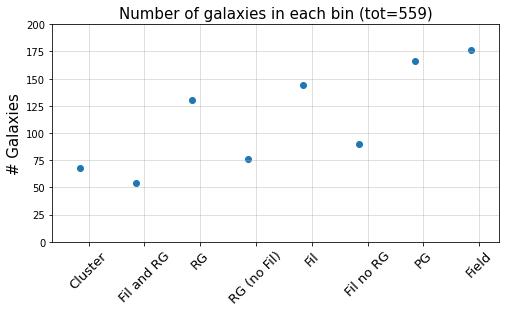

In [48]:
#first plot num of galaxies in each bin
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ind=np.arange(0,8,1)
width=0.15

x = np.array([1,2,3,4,5,6,7,8])-1
data1 = np.array([len(cluster_re_free),len(fil_rg_re_free),len(rg_all_re_free),len(rg_re_free),
                 len(filament_re_free),len(fil_iso_re_free),len(pg_re_free),len(field_re_free)])

plt.scatter(x,data1)
plt.title('Number of galaxies in each bin (tot='+str(len(re_ratio_2))+')',fontsize=15)
plt.ylabel('# Galaxies',fontsize=15)
plt.ylim(0,200)

ax.set_xlim(-width,len(ind)-1.5*width)
xTickMarks= ['Cluster','Fil and RG','RG','RG (no Fil)','Fil','Fil no RG','PG','Field']
ax.set_xticks(ind+width)
xtickNames=ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames,rotation=45,fontsize=13)
plt.xlim(-0.5,7.5)
plt.grid(alpha=0.5)

## Violin Plot...

Text(0, 0.5, 'R$_e$ Ratios (12$\\mu$m/optical)')

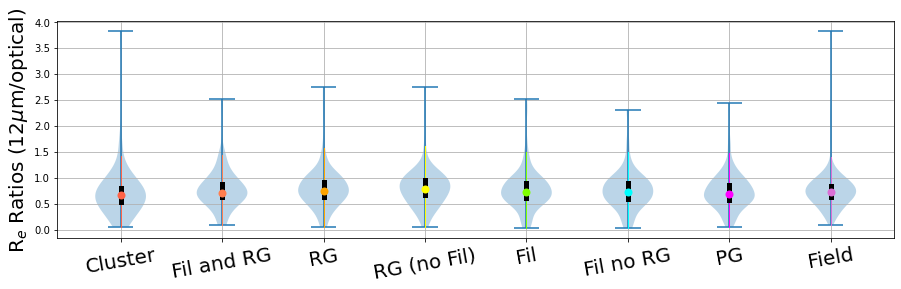

In [49]:
env_names = ['Cluster','Fil and RG','RG','RG (no Fil)','Fil','Fil no RG','PG','Field']
#x axis --> env names; y axis --> Re ratios

#set up the canvas
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))

#data corresponding, I assume, to each env bin. I will populate the list as such
data =[cluster_re_free, fil_rg_re_free, rg_all_re_free, rg_re_free, filament_re_free, fil_iso_re_free,
       pg_re_free, field_re_free]

# mod = mode?
mod = []

# median
med = []

# inter-quartile ranges; IQR = stats.iqr(data, interpolation = 'midpoint')
iqr = []

# upper and lower adjacent values
# UAV = Q3 + 1.5*IQR 
# LAV = Q1 - 1.5*IQR
avs = []

#taken from https://matplotlib.org/2.0.2/examples/statistics/customized_violin_demo.html
def adjacent_values(vals):  
    q1 = np.percentile(vals,25)
    q3 = np.percentile(vals,75)
    upper_adjacent_value = q3 + ((q3 - q1) * 1.5)
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])
    lower_adjacent_value = q1 - ((q3 - q1) * 1.5)
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value   

for arr in data:
    sarr = sorted(arr)
    med.append(percentile(sarr, 50))   #used 50 instead of 0.5
    mod.append(stats.mode(np.asarray(sarr)[np.isfinite(sarr)].astype(int)))
    iqr.append([percentile(sarr, 32), percentile(sarr, 68)])   #used 32, 68 instead of 0.32, 0.68
    avs.append(adjacent_values(sarr))
    
plt.rcParams['axes.axisbelow'] = True
plt.rc('grid', c='0.5', ls='-', lw=0.2)
plt.grid(True)

ticks=np.arange(0,8,1)
parts = ax.violinplot(data, positions=ticks,widths =0.5, showmeans=False, showmedians=False,
                  showextrema=True)

med_col = ['tomato','coral','orange','yellow','chartreuse','cyan','fuchsia','orchid']
avs_col = ['tomato','coral','orange','yellow','chartreuse','cyan','fuchsia','orchid']

for i in range(len(med)):
    ax.plot([i, i], avs[i], '-', lw=1, zorder = 7,color=avs_col[i])
    ax.plot([i, i], iqr[i], '-', lw=5, zorder = 7,color='black')
    ax.plot(i, med[i], 'o', mec='none', ms=8, zorder = 7,color=med_col[i],label=str(env_names[i])+' Median')

med_ld = med
err_ld = iqr

plt.xticks(ticks,env_names, rotation=10, fontsize=20)

plt.ylabel(r"R$_e$ Ratios (12$\mu$m/optical)",fontsize=20)
#plt.legend()
#plt.yscale('log')

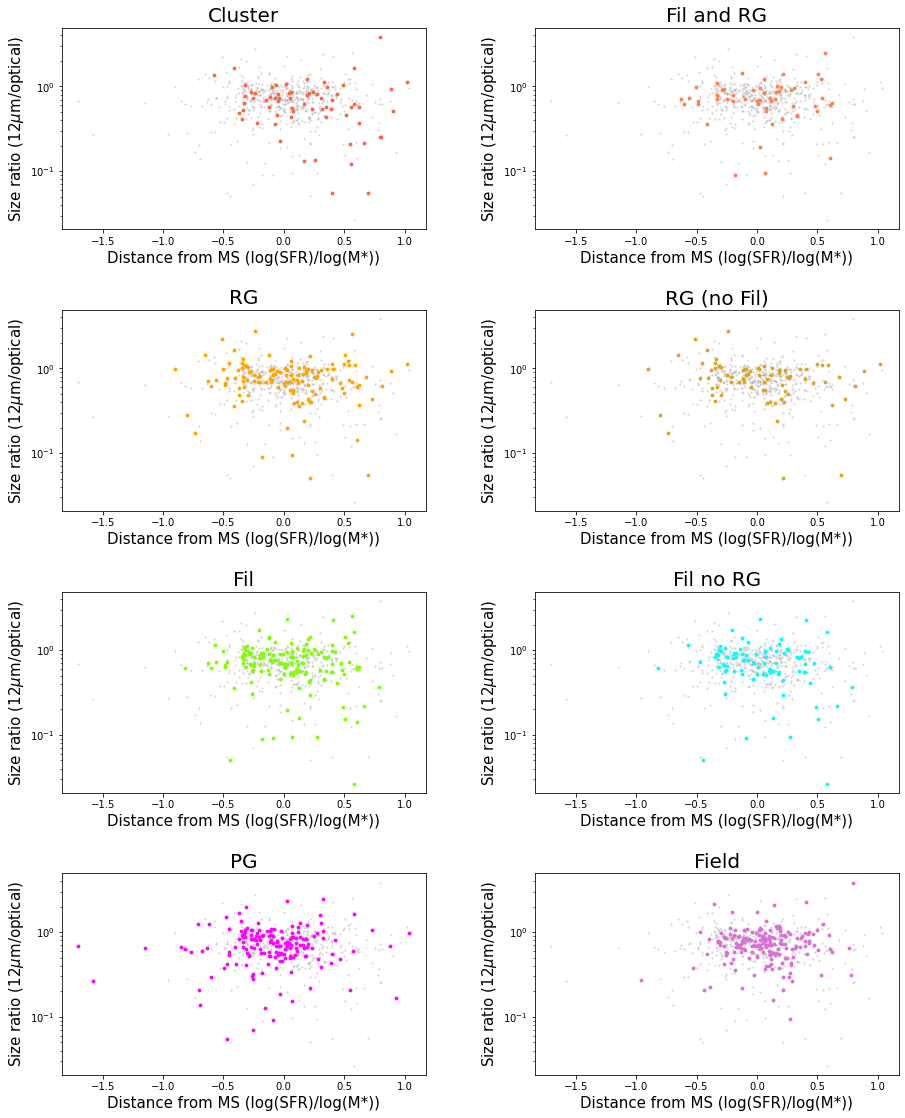

In [50]:
d2_all = [d2[cluster_free], d2[fil_rg_free], d2[rg_all_free], d2[rg_free], d2[filament_free], 
          d2[filament_iso_free], d2[pg_free], d2[field_free]]
re_ratio_2_all = [cluster_re_free, fil_rg_re_free, rg_all_re_free, rg_re_free, filament_re_free, fil_iso_re_free,
                 pg_re_free, field_re_free]
env_names = ['Cluster', 'Fil and RG', 'RG', 'RG (no Fil)', 'Fil', 'Fil no RG', 'PG', 'Field']
colors = ['tomato','coral','orange','goldenrod','chartreuse','cyan','fuchsia','orchid']


fig = plt.figure(figsize=(15,40))
plt.subplots_adjust(hspace=0.4,wspace=0.3)
for i in range(1,9):
    ax=fig.add_subplot(8,2,i)
    plt.scatter(d2,re_ratio_2,color='gray',s=2,alpha=0.2,label='sample')
    plt.scatter(d2_all[i-1],re_ratio_2_all[i-1],color=colors[i-1],s=8,alpha=1,label=env_names[i-1])
    plt.yscale('log')
    plt.ylabel(r'Size ratio (12$\mu$m/optical)',fontsize=15)
    plt.xlabel('Distance from MS (log(SFR)/log(M*))',fontsize=15)  
    plt.title(env_names[i-1],fontsize=20)

## Run K-S tests on size ratio distributions in each environment vs. field and vs. cluster.

In [51]:
from scipy.stats import kstest

In [52]:
print('fil+rg vs. cluster:',kstest(fil_rg_re_free,cluster_re_free))
print('rg_all vs. cluster:',kstest(rg_all_re_free,cluster_re_free))
print('rg_only vs. cluster:',kstest(rg_re_free,cluster_re_free))
print('fil_all vs. cluster:',kstest(filament_re_free,cluster_re_free))
print('fil_only vs. cluster:',kstest(fil_iso_re_free,cluster_re_free))
print('pg vs. cluster:',kstest(pg_re_free,cluster_re_free))
print('field vs. cluster:',kstest(field_re_free,cluster_re_free))

fil+rg vs. cluster: KstestResult(statistic=0.23366013071895425, pvalue=0.06097606299535896)
rg_all vs. cluster: KstestResult(statistic=0.217420814479638, pvalue=0.024145892979244854)
rg_only vs. cluster: KstestResult(statistic=0.21130030959752322, pvalue=0.06768505730532204)
fil_all vs. cluster: KstestResult(statistic=0.1781045751633987, pvalue=0.0921826221714086)
fil_only vs. cluster: KstestResult(statistic=0.15261437908496733, pvalue=0.2904286946774327)
pg vs. cluster: KstestResult(statistic=0.1245570517363572, pvalue=0.4027832832035021)
field vs. cluster: KstestResult(statistic=0.18315508021390375, pvalue=0.06412900428045998)


In [53]:
print('fil+rg vs. field:',kstest(fil_rg_re_free,field_re_free))
print('rg_all vs. field:',kstest(rg_all_re_free,field_re_free))
print('rg_only vs. field:',kstest(rg_re_free,field_re_free))
print('fil_all vs. field:',kstest(filament_re_free,field_re_free))
print('fil_only vs. field:',kstest(fil_iso_re_free,field_re_free))
print('pg vs. field:',kstest(pg_re_free,field_re_free))

fil+rg vs. field: KstestResult(statistic=0.07617845117845118, pvalue=0.9517384459561452)
rg_all vs. field: KstestResult(statistic=0.1222027972027972, pvalue=0.1932362287918017)
rg_only vs. field: KstestResult(statistic=0.16208133971291866, pvalue=0.10793620202154774)
fil_all vs. field: KstestResult(statistic=0.08080808080808081, pvalue=0.6441134441924549)
fil_only vs. field: KstestResult(statistic=0.09494949494949495, pvalue=0.612120882582009)
pg vs. field: KstestResult(statistic=0.07954545454545454, pvalue=0.6123487207510356)


# ---------------------------------------------------------------------------------------

### Action Items
-run galfit with new psf \
-CO galaxies \
-bootstrap algorithm \
-try to recreate a version of Rose's plot (see notes on office desk)

# Small size-ratio galaxy subsample for potential Virgo CO proposal.

## Defining Subsample

In [120]:
#note...ALL of the below cells effectively conspired to generate the following table:

tab_co = Table.read('small_rats.fits')

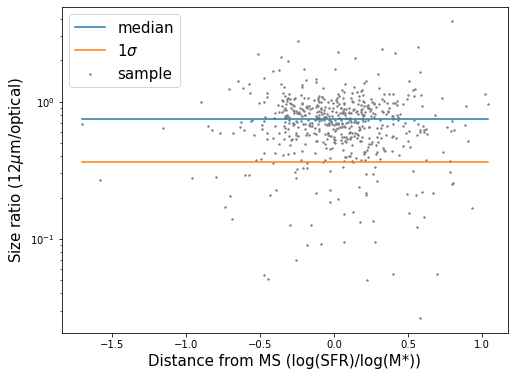

In [69]:
#Isolate all points underneath 1-sigma of the mean

#NOTEEEEEEE --> USE MEDIAN INSTEAD OF MEAN? MAY HELP WITH THE SKEWING OF MEAN DUE TO OUTLIERS

#mean_re = np.mean(re_ratio_2)
mean_re = np.mean(re_ratio_2)

std_re = np.std(re_ratio_2)


plt.figure(figsize=(8,6))

plt.scatter(d2,re_ratio_2,color='gray',s=2,label='sample')

plt.plot([np.min(d2),np.max(d2)],[mean_re,mean_re],label='median')
plt.plot([np.min(d2),np.max(d2)],[mean_re-std_re,mean_re-std_re],label=r'1$\sigma$')
plt.legend(fontsize=15)
plt.ylabel(r'Size ratio (12$\mu$m/optical)',fontsize=15)
plt.xlabel('Distance from MS (log(SFR)/log(M*))',fontsize=15)
plt.yscale('log')

In [70]:
subsample_flag = (re_ratio_2 < (mean_re - std_re))
vfid_2[np.where(re_ratio_2<0.05)[0]]

VFID6420


In [71]:
hyp_2 = hyp[t2_error]

In [72]:
#table of vfids, re_ratios
ra_2 = hyp_2['RA'][subsample_flag]
dec_2 = hyp_2['DEC'][subsample_flag]
header_t = ['VFID','RA','DEC','re_ratio','ms_offset','robust_flag']
robust_flag = [False,False,False,True,False,True,True,False,False,False,False,False,True,True,
              True,True,False,True,True,True,False,True,True,True,True,False,True,False,False,
              False,False,False,True,False,True,True,True,False,True,True,False,True,True,True,
              True,True,False,True,True,True,False,True,False,True,True,True,True,True,True,False,
              False,True]

robust_flag_noAGN = [False,False,False,True,False,True,True,False,False,False,False,False,True,True,
              False,True,False,True,True,True,False,True,False,False,False,False,False,False,False,
              False,False,False,True,False,True,True,True,False,True,True,False,True,True,True,
              True,True,False,False,True,True,False,True,False,True,True,True,True,True,False,False,
              False,True]

t = Table([vfid_2[subsample_flag],ra_2,dec_2,re_ratio_2[subsample_flag],d2[subsample_flag],
           robust_flag],names=header_t)

In [73]:
#ascii.write(t,'co_galaxies.csv',format='csv',overwrite=True)
#note: table is cut according to SNR>20, T-type>1, no GALFIT error flags
#I will now cut the CO table according to the VFIDs in table t
tab = t[robust_flag]
tab_noAGN = t[robust_flag_noAGN]
print('with AGN:',len(tab))
print('without AGN:',len(tab_noAGN))

with AGN: 37
without AGN: 30


## Size ratio v. MS offset (with CO detections)

In [75]:
co_table = Table.read(homedir+'/Desktop/v1-20210308/vf_north_v1_co.fits')

co_flag = []
for i in co_table['VFID']:
    if i in vfid_2:
        co_flag.append(True)
    else:
        co_flag.append(False)

In [76]:
co_t = co_table[co_flag]

In [77]:
co_t_flag = co_t['COflag']

NameError: name 'tab_co' is not defined

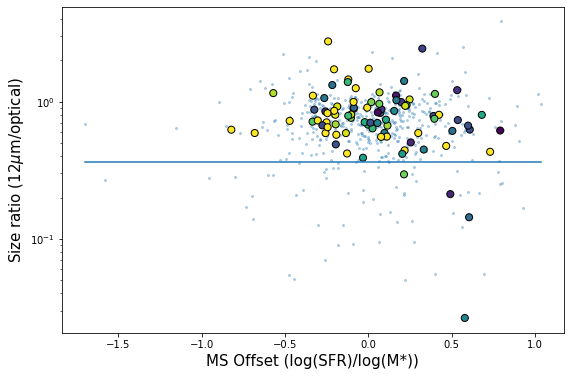

In [78]:
plt.figure(figsize=(9,6))
plt.scatter(d2,re_ratio_2,s=4,alpha=0.3,label='sample')
plt.yscale('log')
plt.ylabel(r'Size ratio (12$\mu$m/optical)',fontsize=15)
plt.xlabel('MS Offset (log(SFR)/log(M*))',fontsize=15)

plt.scatter(d2[co_t_flag], re_ratio_2[co_t_flag], s=50, 
            edgecolors='black',c=co_t['Mmol_to_Mstar'][co_t_flag],label='CO Detections',vmax=0.1)

plt.plot([np.min(d2),np.max(d2)],[mean_re-std_re,mean_re-std_re],label=r'1$\sigma$')

plt.scatter(tab_co['ms_offset'],tab_co['re_ratio'],s=90, facecolors='none', 
            edgecolors='r',label='subset galaxies')

cb = plt.colorbar()
cb.set_label(r'[M$_{mol}$/M$_*$]',fontsize=20)

plt.legend(loc='upper left',fontsize=12)
plt.title('# CO Detections: 85',fontsize=20)

#plt.savefig('co_rat.png', dpi=300)

In [87]:
#two encircled CO galaxies: VFID3864 in field; VFID6420 in filament

## Size ratio v. MS offset (with HI detections)

Text(0.5, 1.0, '# HI Detections: 85')

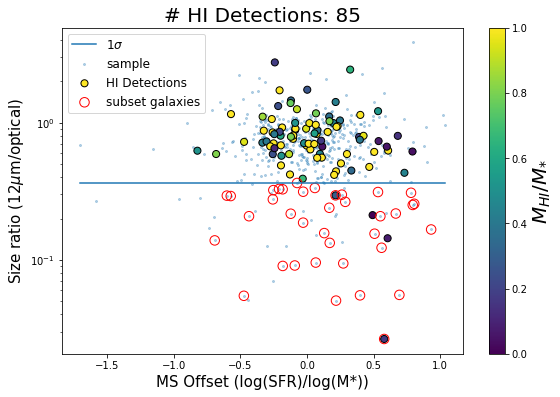

In [88]:
plt.figure(figsize=(9,6))
plt.scatter(d2,re_ratio_2,s=4,alpha=0.3,label='sample')
plt.yscale('log')
plt.ylabel(r'Size ratio (12$\mu$m/optical)',fontsize=15)
plt.xlabel('MS Offset (log(SFR)/log(M*))',fontsize=15)

plt.scatter(d2[co_t_flag], re_ratio_2[co_t_flag], s=50, 
            edgecolors='black',c=co_t['MHI_to_Mstar'][co_t_flag],label='HI Detections',vmax=.3)

plt.plot([np.min(d2),np.max(d2)],[mean_re-std_re,mean_re-std_re],label=r'1$\sigma$')

plt.scatter(tab_co['ms_offset'],tab_co['re_ratio'],s=90, facecolors='none', 
            edgecolors='r',label='subset galaxies')

cb = plt.colorbar()
cb.set_label(r'$M_{HI}/M_{*}$',fontsize=20)

plt.legend(loc='upper left',fontsize=12)
plt.title('# HI Detections: 85',fontsize=20)

#plt.savefig('HI_rat.png', dpi=300)

In [89]:
#recreate above plot with ALFALFA HI measurements

#read a100 v2 table, which contains logMH column.
a100_v2 = Table.read(homedir+'/Downloads/vf_v2_a100.fits')
#v2 main catalog
ghoti = Table.read(homedir+'/Downloads/vf_v2_main.fits')
#v1 main catalog
ghoti_v1 = Table.read(homedir+'/Desktop/v1-20210308/vf_north_v1_main.fits')

#add v1 names (from v2 catalog) to a100 v2 catalog
a100_v2.add_column(ghoti['VFID_V1'],name='VFID_V1')

In [90]:
HI_flag = []
for i in a100_v2['VFID_V1']:
    if i in vfid_2:
        HI_flag.append(True)
    else:
        HI_flag.append(False)
        
#add table with M*
#in a distant cell, I defined mgs, which has logmass in units of solar masses (fortunately, logMHI is also
#in units of solar masses)

mgs_flag = []
for i in ghoti_v1['VFID']:
    if i in a100_v2['VFID_V1'][HI_flag]:
        mgs_flag.append(True)
    else:
        mgs_flag.append(False)

mgs_hi = mgs[mgs_flag]
a100_v2_hi = a100_v2[HI_flag]

In [91]:
logMH = a100_v2_hi['logMH']
logmstar = mgs_hi['logmass']

In [92]:
HI_mstar_ratio = (10**logMH)/(10**logmstar)
#removed galaxies with REAL small ratios, which indicates a lack of HI measurements (the column places a 0. in the
#cell, which python oddly rounds to a nonzero value...this number is then divided by a LARGE stellar mass)

hiflag = (HI_mstar_ratio>0.0001)

Text(0.5, 1.0, '# HI Detections: 248')

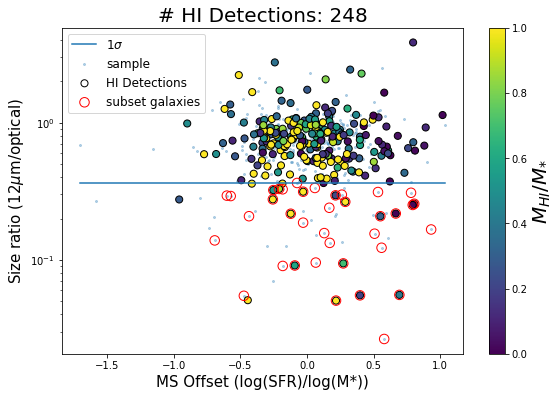

In [93]:
plt.figure(figsize=(9,6))
plt.yscale('log')
plt.ylabel(r'Size ratio (12$\mu$m/optical)',fontsize=15)
plt.xlabel('MS Offset (log(SFR)/log(M*))',fontsize=15)

plt.scatter(d2,re_ratio_2,s=4,alpha=0.3,label='sample')

plt.scatter(d2[hiflag], re_ratio_2[hiflag], s=50, edgecolors='black',
            c=HI_mstar_ratio[hiflag],vmax=.5,label='HI Detections')

plt.plot([np.min(d2),np.max(d2)],[mean_re-std_re,mean_re-std_re],label=r'1$\sigma$')

plt.scatter(tab_co['ms_offset'],tab_co['re_ratio'],s=90, facecolors='none', 
            edgecolors='r',label='subset galaxies')

cb = plt.colorbar()
cb.set_label(r'$M_{HI}/M_{*}$',fontsize=20)

plt.legend(loc='upper left',fontsize=12)
plt.title('# HI Detections: '+str(len(HI_mstar_ratio[hiflag])),fontsize=20)

#plt.savefig('HI_Mstar.png', dpi=300)

In [94]:
above = []
below = []
rerat = re_ratio_2[hiflag]
for i in range(0,len(rerat)):
    if str(rerat[i]) == 'masked':
        continue
    if float(rerat[i]) >= (mean_re-std_re):
        above.append(HI_mstar_ratio[hiflag][i])
    if float(rerat[i]) < (mean_re-std_re):
        below.append(HI_mstar_ratio[hiflag][i])
    


In [99]:
a100_v2_hi_flag = []
for i in a100_v2_hi['VFID_V1']:
    if i in tab_co['VFID']:
        a100_v2_hi_flag.append(True)
    else:
        a100_v2_hi_flag.append(False)

In [100]:
HI_mstar_subset = HI_mstar_ratio[a100_v2_hi_flag]
len(HI_mstar_subset)

37

In [103]:
#add MHI ratio column to tab_co table
#tab_co.add_column(HI_mstar_subset,name='MHI_Mstar_rat')

In [105]:
#add MHI ratio flag...False for those with <0.00001 (which, again, signals a missing MHI value)
HI_mstar_subset_flag = (HI_mstar_subset>0.00001)
#tab_co.add_column(HI_mstar_subset_flag,name='MHI_flag')

Text(0.5, 0, '$M_{HI}/M_{*}$')

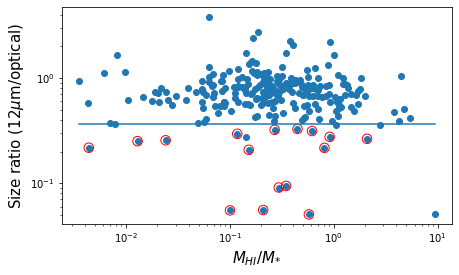

In [106]:
#now plot size ratio vs. MHI ratio. 
#note the scatter of MHI ratios for small size ratios; Rose's LCS paper found a correlation between these two
#quantities, whereas there appears to be scatter without noticeable relationship. perhaps the "trouble" is the 
#small sample size?

plt.figure(figsize=(7,4))

plt.scatter(HI_mstar_ratio[hiflag],re_ratio_2[hiflag])
plt.plot([np.min(HI_mstar_ratio[hiflag]),np.max(HI_mstar_ratio[hiflag])],[mean_re-std_re,mean_re-std_re],label=r'1$\sigma$')
plt.yscale('log')
plt.xscale('log')
plt.scatter(tab_co['MHI_Mstar_rat'][tab_co['MHI_flag']],tab_co['re_ratio'][tab_co['MHI_flag']],s=90,
            facecolors='none', edgecolors='r',label='subset galaxies')

plt.ylabel(r'Size ratio (12$\mu$m/optical)',fontsize=15)
plt.xlabel(r'$M_{HI}/M_{*}$',fontsize=15)


In [107]:
#CO 2-1 transitions

Text(0.5, 1.0, '# HI Detections: 85')

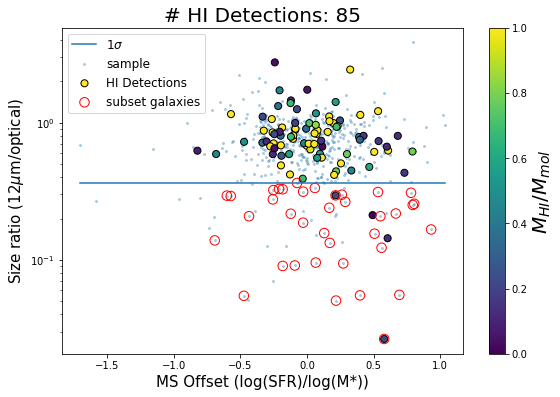

In [108]:
Mmol = co_t['Mmol']
MHI = co_t['MHI']
MHI_to_Mmol = MHI/Mmol

plt.figure(figsize=(9,6))
plt.scatter(d2,re_ratio_2,s=4,alpha=0.3,label='sample')
plt.yscale('log')
plt.ylabel(r'Size ratio (12$\mu$m/optical)',fontsize=15)
plt.xlabel('MS Offset (log(SFR)/log(M*))',fontsize=15)

plt.scatter(d2[co_t_flag], re_ratio_2[co_t_flag], s=50, 
            edgecolors='black',c=MHI_to_Mmol[co_t_flag],label='HI Detections',vmax=5)

plt.scatter(tab_co['ms_offset'],tab_co['re_ratio'],s=90, facecolors='none', 
            edgecolors='r',label='subset galaxies')

plt.plot([np.min(d2),np.max(d2)],[mean_re-std_re,mean_re-std_re],label=r'1$\sigma$')


cb = plt.colorbar()
cb.set_label(r'$M_{HI}/M_{mol}$',fontsize=20)

plt.legend(loc='upper left',fontsize=12)
plt.title('# HI Detections: 85',fontsize=20)

## Plot of Small Size Ratio Galaxies per Environment Bin

In [109]:
#first truncate (pun intended) envcut to only include the 37 galaxy subset
envcut_flag = []
for i in envcut['VFID']:
    if i in tab['VFID']:
        envcut_flag.append(True)
    else:
        envcut_flag.append(False)
env_co = envcut[envcut_flag]

In [110]:
#isolate columns; convert 0,1 to False,True

cluster_co = env_co['flag_clus']
cluster_co = np.asarray(list(map(bool,cluster_co)))

filament_co = env_co['flag_fil']
filament_co = np.asarray(list(map(bool,filament_co)))

field_co = env_co['flag_isol']
field_co = np.asarray(list(map(bool,field_co)))

group_co = env_co['flag_gro']
#poor group
pg_flag_co = []
#rich group
rg_flag_co = []

#define rich, poor groups 

for n in range(0,len(env_co)):
    if int(group_co[n]) == 1:
        rg_flag_co.append(False)
        pg_flag_co.append(True)
    if int(group_co[n]) == 2:
        rg_flag_co.append(True)
        pg_flag_co.append(False)
    if int(group_co[n]) == 0:
        rg_flag_co.append(False)
        pg_flag_co.append(False)
        
rg_flag_co = np.asarray(rg_flag_co)
pg_flag_co = np.asarray(pg_flag_co)

In [111]:
#CL
cluster_co = cluster_co

#Filament and rich group
fil_rg_co = (rg_flag_co & filament_co)

#rich group (all, meaning isolated rich groups or those in filaments)
rg_all_co = (rg_flag_co)

#rich group only (include if the row only has a "2")
rg_co = (rg_flag_co) & (~fil_rg_co)

#filament (all galaxies with filament marker)
filament_co = filament_co

#filament galaxies that do not belong to a rich group
fil_only_co = (filament_co) & (~rg_flag_co)

#poor group
pg_flag_co = pg_flag_co

#pure field
field_co = field_co

In [112]:
env_flags_co = [cluster_co, fil_rg_co, rg_all_co, rg_co, filament_co, fil_only_co, pg_flag_co, field_co]
env_names_co = ['cluster_flag', 'fil_rg_flag', 'rg_all_flag', 'rg_only_flag', 'fil_all_flag', 
                'fil_only_flag', 'pg_only_flag', 'field_flag']

In [86]:
tab_co = tab
tab_co_noAGN = tab_noAGN

In [113]:
tab_co.add_columns(env_flags_co,names=env_names_co)

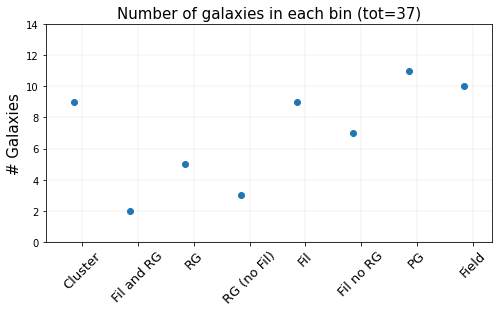

In [114]:
#first plot num of galaxies in each bin
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ind=np.arange(0,8,1)
width=0.15

x = np.array([1,2,3,4,5,6,7,8])-1
data1 = np.array([len(tab_co[tab_co['cluster_flag']]),len(tab_co[tab_co['fil_rg_flag']]),
                  len(tab_co[tab_co['rg_all_flag']]),len(tab_co[tab_co['rg_only_flag']]),
                 len(tab_co[tab_co['fil_all_flag']]),len(tab_co[tab_co['fil_only_flag']]),
                  len(tab_co[tab_co['pg_only_flag']]),len(tab_co[tab_co['field_flag']])])

plt.scatter(x,data1)
plt.title('Number of galaxies in each bin (tot='+str(len(tab_co))+')',fontsize=15)
plt.ylabel('# Galaxies',fontsize=15)
plt.ylim(0,14)

ax.set_xlim(-width,len(ind)-1.5*width)
xTickMarks= ['Cluster','Fil and RG','RG','RG (no Fil)','Fil','Fil no RG','PG','Field']
ax.set_xticks(ind+width)
xtickNames=ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames,rotation=45,fontsize=13)
plt.xlim(-0.5,7.5)
plt.grid(alpha=0.5)

In [115]:
tab_co.add_column(a100_v2_hi['W50'][a100_v2_hi_flag],name='W50_kms')

In [116]:
#boss also wants SFR_MS
#equation (from Rfinn): y = 0.47x - 4.88, where x == Mstar

In [121]:
mstarr = tab_co['logmass']
sfr_ms = mstarr*0.47 - 4.88

In [ ]:
tab_co.write('small_rats.fits',overwrite=True)